In [48]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [49]:
import numpy as np
import pandas as pd

In [50]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [51]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [52]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [53]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [54]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [57]:
m_row =session.query(Measurement).first()
m_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2c53dcab048>,
 'station': 'USC00519397',
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [58]:
s_row = session.query(Station).first()
s_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2c53dcad788>,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Climate Analysis

In [96]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date=session.query(Measurement.date).group_by(Measurement.date).order_by(Measurement.date.desc()).first().date

last_date

'2017-08-23'

In [97]:
#year_ago =dt.date(last_date)-dt.timedelta(days=365) need to ask how to use variable last_day
#print(year_ago)

In [99]:
# Calculate the date 1 year ago from the last data point in the database
year_ago =(dt.datetime.strptime(last_date, "%Y-%m-%d")-dt.timedelta(days=365)).date()
year_ago

datetime.date(2016, 8, 23)

In [62]:
# Perform a query to retrieve the data and precipitation scores
prcp_score = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date <= last_date).\
filter(Measurement.date>= year_ago).all()
#prcp_score

In [104]:
# Save the query results as a Pandas DataFrame and 
#set the index to the date column . 
prcp_df = pd.DataFrame(prcp_score).set_index('date')
prcp_df.head()

In [64]:
prcp_df.count()

prcp    2021
dtype: int64

In [65]:
prcp_df.fillna(0).count()

prcp    2230
dtype: int64

In [66]:
# Sort the dataframe by date why need to sort?
prcp_df.sort_index(axis=0)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


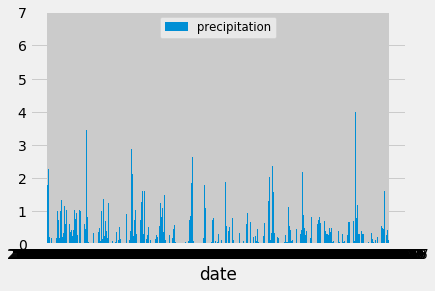

In [67]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(prcp_df.index,prcp_df['prcp'],label = 'precipitation')
plt.legend(loc="upper center", fontsize="small")
plt.xlabel("date")
plt.savefig("Outputs/Precipitation")
plt.show()

![precipitation](Images/precipitation.png)

In [68]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

# Station analysis

In [69]:
# Design a query to show how many stations are available in this dataset?
station_num = session.query(Measurement.station).group_by(Measurement.station).count()
station_num

9

In [70]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [71]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = station_count[0][0]
result = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active).all()
result

[(54.0, 85.0, 71.66378066378067)]

# the most active staion last 12 month tobs analysis

In [72]:
last_date_activestation = session.query(Measurement.date).\
filter(Measurement.station==most_active).\
order_by(Measurement.date.desc()).first()
last_date_activestation

('2017-08-18')

In [73]:
year_ago_activestation =dt.date(2017,8,18)-dt.timedelta(days=365)

In [74]:
tobs_activestation=session.query(Measurement.tobs,Measurement.date).\
filter(Measurement.station ==most_active).\
filter(Measurement.date>=year_ago_activestation).all()
tobs_activestation =pd.DataFrame(tobs_activestation, columns=['tobs','date']).set_index('date')
tobs_activestation.head()

,tobs
date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


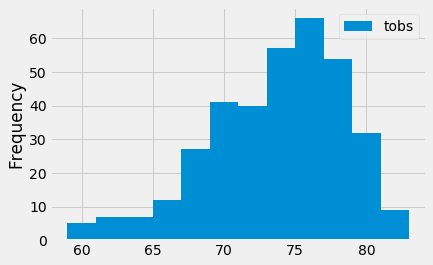

In [75]:
plt.hist(tobs_activestation['tobs'], label='tobs',bins = 12)
plt.ylabel("Frequency")
plt.legend(loc='best')
plt.savefig("Outputs/Most active station's tobs")
plt.show()

![precipitation](Images/station-histogram.png)

# Bonus optional

# Calc_temps. trip temperature analysis

In [83]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [84]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date ='2014-03-05'
trip_end_date='2014-03-14'
trip_data = calc_temps(trip_start_date, trip_end_date)
trip_data

[(60.0, 69.57894736842105, 75.0)]

In [85]:
trip_df=pd.DataFrame(trip_data, columns=['min_t','avg_t','max_t'])
trip_df

,min_t,avg_t,max_t
0,60.0,69.578947,75.0


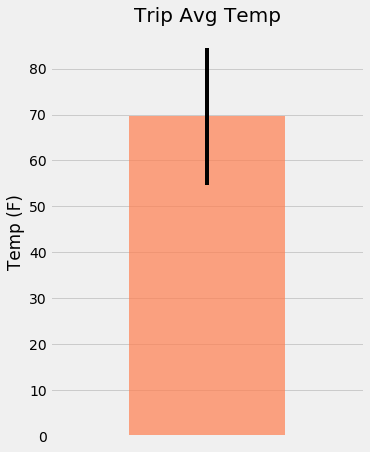

In [86]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df['avg_t'].plot(kind='bar',yerr=trip_df['max_t']-trip_df['min_t'],figsize=(5,7), alpha=0.7, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.savefig("Outputs/Trip Ave Temp")
plt.show()

In [87]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_info=session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
group_by(Measurement.station).\
filter(Measurement.station == Station.station).\
filter(Measurement.date<=trip_end_date).\
filter(Measurement.date>=trip_start_date).\
order_by(func.sum(Measurement.prcp).desc()).all()
station_info

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0)]

# Optional Challenge Assignment

# calculate the daily normals for your trip

In [105]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [106]:
# Set the start and end date of the trip
trip_start_date ='2014-03-05'
trip_end_date='2014-03-14'

In [107]:
# Use the start and end date to create a range of dates
trip_range =pd.date_range(start = trip_start_date, end = trip_end_date)

In [108]:
# Stip off the year and save a list of %m-%d strings
trip_range_md= trip_range.strftime("%m-%d")
trip_range_md


Index(['03-05', '03-06', '03-07', '03-08', '03-09', '03-10', '03-11', '03-12',
       '03-13', '03-14'],
      dtype='object')

In [111]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals =[daily_normals(day)for day in trip_range_md]
min_t=[normals[i][0][0]for i in range(len(trip_range_md))]
avg_t=[normals[i][0][1]for i in range(len(trip_range_md))]
max_t=[normals[i][0][2]for i in range(len(trip_range_md))]
normal_df =pd.DataFrame({"min_t":min_t,"avg_t":avg_t,"max_t":max_t, "date":trip_range}).set_index("date")
normal_df.head(2)

,min_t,avg_t,max_t
date,,,
2014-03-05,60.0,67.890909,76.0
2014-03-06,60.0,69.203390,76.0


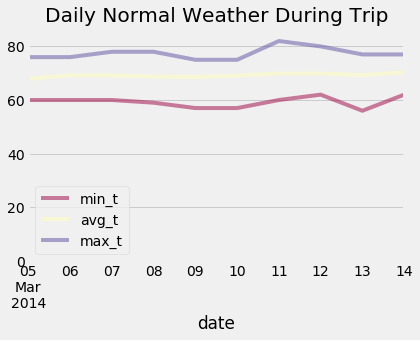

In [114]:
normal_df.plot(kind='line',stacked=False, alpha=0.5, colormap='Spectral',
        title='Daily Normal Weather During Trip')
plt.ylim(0,max(max_t)+5)
plt.savefig("Outputs/Daily Normals")
plt.show()

In [94]:
# Plot the daily normals as an area plot with `stacked=False`
